In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

plt.style.use("seaborn-v0_8")
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# Load CSV
data = pd.read_csv("data/coin_Bitcoin.csv", parse_dates=["Date"])

# Select columns and avoid warnings
df = data[["Date", "High", "Low", "Open", "Close"]].copy()
df = df.set_index("Date").sort_index()

# Create returns
df["pct_return"] = df["Close"].pct_change()
df["log_return"] = np.log1p(df["pct_return"])
df = df.dropna()

df.head()

,High,Low,Open,Close,pct_return,log_return
Date,,,,,,
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,-0.038328,-0.039082
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,-0.158345,-0.172385
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,-0.100692,-0.106130
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,-0.070906,-0.073545
2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.150895,0.140540


In [ ]:
# Setup to predict next day close
feature_cols = ["Close", "log_return"]
features = df[feature_cols].values
targets = df[["Close"]].values


In [9]:
# Train Test Split
split_idx = int(len(features) * 0.8)

X_train_raw, X_test_raw = features[:split_idx], features[split_idx:]
y_train_raw, y_test_raw = targets[:split_idx], targets[split_idx:]

print(X_train_raw.shape, X_test_raw.shape)


(2288, 2) (573, 2)


In [10]:
# Scale features and targets separately
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train = feature_scaler.fit_transform(X_train_raw)
X_test  = feature_scaler.transform(X_test_raw)

y_train = target_scaler.fit_transform(y_train_raw)
y_test  = target_scaler.transform(y_test_raw)


In [11]:
# Sequence Dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len=100):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.seq_len]
        y_seq = self.y[idx + self.seq_len]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)


In [12]:
# Create datasets and loaders
seq_len = 100

train_ds = SequenceDataset(X_train, y_train, seq_len)
test_ds  = SequenceDataset(X_test,  y_test,  seq_len)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

len(train_ds), len(test_ds)


(2188, 473)

In [13]:
# Define Model
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # take last time step
        return self.fc(last)


In [14]:
# Initialize Model
model = LSTMRegressor(input_dim=2, hidden_dim=32).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
# Train Model
epochs = 30

model.train()
for epoch in range(1, epochs + 1):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch}/{epochs}  Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/30  Loss: 0.0254
Epoch 2/30  Loss: 0.0020
Epoch 3/30  Loss: 0.0009
Epoch 4/30  Loss: 0.0007
Epoch 5/30  Loss: 0.0007
Epoch 6/30  Loss: 0.0006
Epoch 7/30  Loss: 0.0005
Epoch 8/30  Loss: 0.0004
Epoch 9/30  Loss: 0.0004
Epoch 10/30  Loss: 0.0004
Epoch 11/30  Loss: 0.0004
Epoch 12/30  Loss: 0.0003
Epoch 13/30  Loss: 0.0003
Epoch 14/30  Loss: 0.0003
Epoch 15/30  Loss: 0.0003
Epoch 16/30  Loss: 0.0003
Epoch 17/30  Loss: 0.0003
Epoch 18/30  Loss: 0.0003
Epoch 19/30  Loss: 0.0003
Epoch 20/30  Loss: 0.0003
Epoch 21/30  Loss: 0.0002
Epoch 22/30  Loss: 0.0002
Epoch 23/30  Loss: 0.0002
Epoch 24/30  Loss: 0.0003
Epoch 25/30  Loss: 0.0003
Epoch 26/30  Loss: 0.0003
Epoch 27/30  Loss: 0.0003
Epoch 28/30  Loss: 0.0003
Epoch 29/30  Loss: 0.0002
Epoch 30/30  Loss: 0.0003


In [16]:
# Predict 
model.eval()

def predict(loader):
    preds, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            out = model(X_batch).cpu().numpy()
            preds.extend(out)
            actuals.extend(y_batch.numpy())
    return np.array(preds), np.array(actuals)

train_pred_scaled, train_true_scaled = predict(train_loader)
test_pred_scaled, test_true_scaled  = predict(test_loader)


In [ ]:
# Inverse transform back to prices
train_pred = target_scaler.inverse_transform(train_pred_scaled)
train_true = target_scaler.inverse_transform(train_true_scaled)

test_pred = target_scaler.inverse_transform(test_pred_scaled)
test_true = target_scaler.inverse_transform(test_true_scaled)


In [ ]:
# Evaluate Root mean sqaure error
train_rmse = mean_squared_error(train_true, train_pred) ** 0.5
test_rmse  = mean_squared_error(test_true,  test_pred) ** 0.5

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 282.42996919590524
Test RMSE: 3056.6295163136797


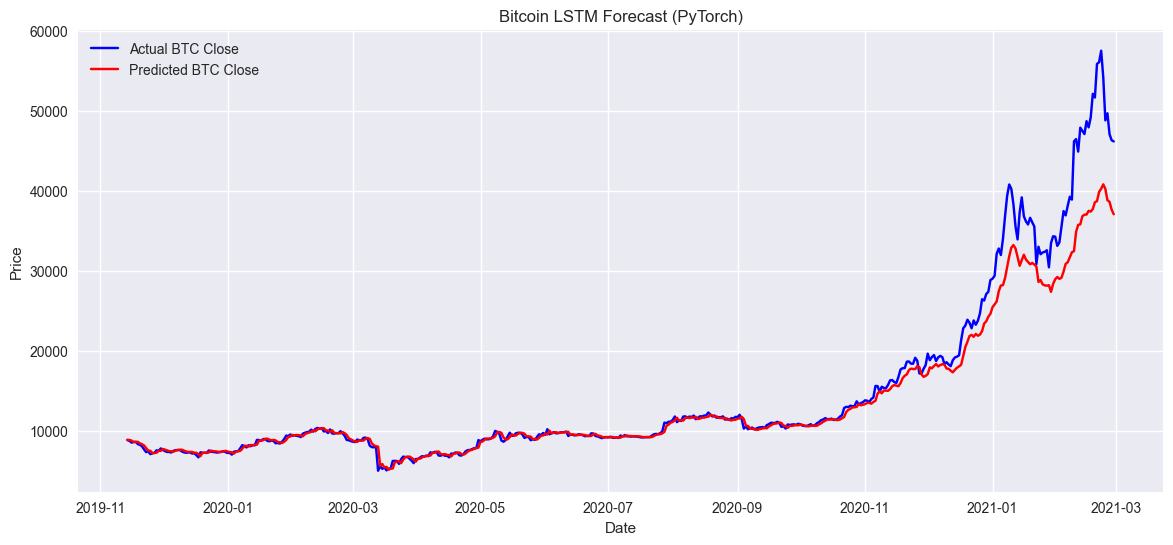

In [ ]:
# Create date index
test_index = df.index[split_idx + seq_len:]

plt.figure(figsize=(14, 6))
plt.plot(test_index, test_true.flatten(), label="Actual BTC Close", color="blue")
plt.plot(test_index, test_pred.flatten(), label="Predicted BTC Close", color="red")
plt.title("Bitcoin LSTM Forecast (PyTorch)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
